In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from scipy.special import expit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import wandb
from sklearn.model_selection import KFold


In [3]:
class MultinomialLogRegression:
    
    def __init__(self,learning_rate,num_epoch,num_classes, num_features):
        self.learning_rate = learning_rate
        self.num_epoch = num_epoch
        self.loss = []
        self.val_acc = []
        self.val_prec = []
        self.val_rec = []
        self.val_f1 = []
        self.train_acc = []
        self.train_prec = []
        self.train_rec = []
        self.train_f1 = []
        self.num_classes = num_classes
        self.num_features = num_features

    def printParameters(self):
        print('---------------------------------------')
        print('Learning Rate  : ',self.learning_rate)
        print('Num Epoches    : ',self.num_epoch)
        print('Num Features   : ',self.num_features)
        print('Num Classes    : ',self.num_classes)
        print('---------------------------------------')
    
    def softmax(self, x):
        sm = np.exp(x)/np.sum(np.exp(x),axis=0)
        return sm
    
    def Softmax(self,z):
        exp = np.exp(z - np.max(z))
        for i in range(len(z)):
            exp[i]/=np.sum(exp[i])
        return exp
    
    def oneHotEncoding(self, y):
        y_encoded = np.zeros((len(y), self.num_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded
    
    def crossEntropyLoss(self,y_hat,y):
        epsilon = 1e-10
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        prob = y_hat[np.arange(len(y)), y]
        loss = -np.mean(np.log(prob))
        return loss            
    
    def fit(self,X_train,y_train,X_val, y_val):
        X = X_train
        y = y_train
        y_one_hot = self.oneHotEncoding(y)
        
        self.w = np.random.random((self.num_features,self.num_classes))
        self.b = np.random.random(self.num_classes)
        
        # gradient descent on w and b
        for epoch in range(self.num_epoch):
            y_hat = self.Softmax(X@self.w + self.b)
            del_w = np.dot(X.T,(y_hat-y_one_hot))
            del_b = np.sum(y_hat-y_one_hot)
            
            self.w = self.w - self.learning_rate*del_w
            self.b = self.b - self.learning_rate*del_b
            
            l = self.crossEntropyLoss(y_hat,y)
            self.loss.append(l)
#             wandb.log({"loss": l, "epoch": epoch}) 
            
            
            # storing validation accuracy and loss (and other metrics)
            self.validate(X_val,y_val)
            
            # storing training accuracy and loss
            y_hat = self.Softmax(X_train@self.w + self.b)
            y_pred_train = np.argmax(y_hat,axis=1)
            acc = accuracy_score(y_train, y_pred_train)
            precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted', zero_division=1)
            self.train_acc.append(acc)
            self.train_prec.append(precision)
            self.train_rec.append(recall)
            self.train_f1.append(f1)
            
            
#             wandb.log({"Train Accuracy": acc, "epoch": epoch}) 
#             wandb.log({"accuracy": acc, "loss": l})
            # if (epoch % (self.num_epoch//10)) ==0:
            #     print('Epoch : ',epoch,' Loss : ',l)
            
        
    def validate(self,X_val, y_val):
        y_hat = self.Softmax(X_val@self.w + self.b)
        y_pred_val = np.argmax(y_hat,axis=1)
        # uncomment this to print classification report after each validation
        # print(classification_report(self.y_val, y_pred_val,zero_division=1))
    
        acc = accuracy_score(y_val, y_pred_val)
        precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_val, average='weighted', zero_division=1)

        self.val_acc.append(acc)
        self.val_prec.append(precision)
        self.val_rec.append(recall)
        self.val_f1.append(f1)

    def predict(self,X_test,y_test, X_val,y_val):
        y_hat = self.Softmax(X_test@self.w + self.b)
        self.y_pred = np.argmax(y_hat,axis=1)
        cr = classification_report(self.y_pred, y_test, zero_division=1)
        # print(cr)
        return self.y_pred,y_hat,cr
#         print('Test Accuracy : ',round(accuracy_score(self.y_test, self.y_pred),3))
#         precision, recall, f1, _ = precision_recall_fscore_support(self.y_test, self.y_pred, average='weighted', zero_division=1)
#         print('Precision     : ',round(precision,3))
#         print('Recall        : ',round(recall,3))
#         print('f1 score      : ',round(f1,3))

        

        
        

In [4]:
class LinearRegressor:
    def __init__(self):
        self.coefficients = None
        self.intercept = None
        self.confidence_metric = None

    def fit(self, X_train, y_train):
        # Add a bias term to the input features
        X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]

        # Compute the coefficients using the normal equation
        self.coefficients = np.linalg.inv(X_train_bias.T.dot(X_train_bias)).dot(X_train_bias.T).dot(y_train)

        # Extract the intercept and coefficients
        self.intercept = self.coefficients[0]
        self.coefficients = self.coefficients[1:]

    def predict(self, X,y):
        # Add a bias term to the input features
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]

        # Predict the target values
        predictions = X_bias.dot(np.insert(self.coefficients, 0, self.intercept))

        return predictions

    def compute_confidence_metric(self, X_val, y_val):
        # Check for NaN values in input features or target values
        if np.isnan(np.sum(X_val)) or np.isnan(np.sum(y_val)):
            self.confidence_metric = np.nan
        else:
            # Use the validation set to compute a performance metric
            predictions = self.predict(X_val,y_val)

            # Calculate Mean Squared Error as a performance metric
            mse = np.mean((y_val - predictions) ** 2)

            # Confidence metric is the inverse of MSE (higher confidence for lower MSE)
            self.confidence_metric = 1 / (1 + mse)

        return self.confidence_metric

    def plot_predictions_vs_actual(self,predictions, actual, title="Predictions vs Actual"):
        """
        Plot predictions and actual values on the same graph as a line plot.

        Parameters:
        - predictions: Numpy array of predicted values
        - actual: Numpy array of actual values
        - title: Title of the plot (default is "Predictions vs Actual")
        """
        plt.figure(figsize=(10, 6))
        plt.plot(predictions, label='Predictions', marker='o')
        plt.plot(actual, label='Actual', marker='x')
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()


In [5]:
class MLP_Classifier:
    
    def __init__(self,layer_sizes, batch_size, num_epoches, learning_rate, activation_function, optimization):
        self.layer_sizes = layer_sizes # number of neurons in each layer
        self.num_layers = len(self.layer_sizes) # total number of layers
        self.batch_size = batch_size # only for mini-batch gradient descent
        self.epoches = num_epoches
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.optimization = optimization
        
        # initializing weights (needed once only)
        self.initialize_weights()
        
        # validation loss and acc
        self.validation_loss = []
        self.validation_accuracy = []
        
        # training loss and acc
        self.L = []
        self.A = []
        
        # print('Initialized values successfully!')
    
    def printParameters(self):
        print('-----------------------------------------------')
        print('Number of Layers       : ',self.num_layers)
        print('Layer sizes            : ',self.layer_sizes)
        print('Batch size             : ',self.batch_size)
        print('Activation Function    : ',self.activation_function)
        print('Optimization Method    : ',self.optimization)
        print('Learning Rate          : ',self.learning_rate)
        print('Num Epoches            : ',self.epoches)
        print('-----------------------------------------------')

    
    # loads the dataframe into the class
    def loadData(self,df):
        self.num_features = df.shape[1]-1
        self.num_classes = df.iloc[:, -1].nunique()
        # print('Loaded Dataframe!')

        
    # returns the one-hot encoded version of a given vector
    def oneHotEncoding(self, y):
        y_encoded = np.zeros((len(y), self.num_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded
    
    def categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.argmax(x,axis=1)
        return categorical

# defining activation functions and their derivatives
#--------------------------------------------------------------------------------------------

    # SIGMOID
    def sigmoid(self,z):
        val = 1/(1+np.exp(-z))
        return val
    def sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    # ReLU 
    def ReLU(self, z):
        ret = np.maximum(z, 0)
        if ret.shape!=z.shape:
            print('whaat??')
        return ret
    def ReLU_prime(self, h):
        return np.where(h >= 0, 1, 0)
    
    # tanh
    def hyperbolic_tan(self, z):
#         val = (2/(np.exp(-2*z)+1)) -1
        val = expit(2 * z) - 1

        return val
    def hyperbolic_tan_prime(self, h):
        return 1-h**2
    
    # linear (can change slope and intercept)
    def linear(self, z):
        return z
    def linear_prime(self,h):
        return 1
    
#-----------------activation function for last layer (output) -------------------------------

    def softmax(self,z):
        ar = np.exp(z-np.max(z))
        return ar/ar.sum(axis=1,keepdims=True)
#         exp = np.exp(z - np.max(z))
#         for i in range(len(z)):
#             exp[i]/=np.sum(exp[i])
#         return exp
    


#---------------------------------------------------------------------------------------------

    def activation(self,z):
        if z.any()>=1e2:
            print('z = ',z)
        if self.activation_function=='sigmoid':
            return self.sigmoid(z)
        elif self.activation_function=='ReLU':
            return self.ReLU(z)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan(z)
        elif self.activation_function=='linear':
            return self.linear(z)
        else:
            raise ValueError("Invalid Activation function")

    def activation_prime(self,h):
        if self.activation_function=='sigmoid':
            return self.sigmoid_prime(h)
        elif self.activation_function=='ReLU':
            return self.ReLU_prime(h)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan_prime(h)
        elif self.activation_function=='linear':
            return self.linear_prime(h)
        else:
            raise ValueError("Invalid Activation function")

#---------------------------------------------------------------------------------------------


    def loss(self, y_hat, y):
        epsilon = 1e-7
        y_hat = y_hat + epsilon
        # adding small value to avoid underflow
        # Compute the loss along the rows, averaging along the number of samples
        return ((-np.log(y_hat))*y).mean()
    
    def accuracy(self, y_hat, y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.sum(y_hat==(y))/len(y_hat)


    
    def initialize_weights(self):
        self.weights = []
        #weights[i] is a m,n matrix giving weight connecting the i and i+1th layer
        
        min_weight = -1
        max_weight = 1
        for i in range(self.num_layers-1):
            sz = [self.layer_sizes[i],self.layer_sizes[i+1]]
            wt = np.random.uniform(min_weight,max_weight,size=sz)
            self.weights.append(wt)
        
#         self.weights = np.asarray(self.weights)
        
    def initialize_layers(self,batch_size):
        self.hidden_layers = [np.ones((batch_size,layer_size)) for layer_size in self.layer_sizes]
        
    # takes in a batch of data (num_samples x num_features) and applies feed-forward on it
    def feedforward(self, batch):
        current_layer = batch
        self.hidden_layers[0] = batch
        
        # next_layer = activation(weights . current_leyer) and storing while feed-forward
        for i,weights in enumerate(self.weights):
            current_layer = self.activation(np.dot(current_layer,weights))
            self.hidden_layers[i+1] = current_layer
            
        # softmax of the last layer is the output layer
        self.output_layer = self.softmax(self.hidden_layers[-1])
        
    # goes from the last layer to the 1st layer updating weights according to GD
    def backpropogation(self, y):
        y = self.oneHotEncoding(y)
        # evaluating the last layer error : del
        del_t = -(y - self.output_layer)*self.activation_prime(self.hidden_layers[-1])
        
        for i in range(1,self.num_layers):
            # calculating the gradient of weights and applying gradient-descent
            dJ_dW = np.dot(self.hidden_layers[-i-1].T,del_t)/self.batch_size
            self.weights[-i] = self.weights[-i] - self.learning_rate * dJ_dW
            # updating the error for the next layer 
            del_t = np.dot(del_t,self.weights[-i].T)*self.activation_prime(self.hidden_layers[-i-1])
                    
    def validate(self,X_val,y_val):
        n,m = X_val.shape[0:2]
        self.initialize_layers(batch_size=n)
        self.feedforward(X_val)
        val_loss = self.loss(self.output_layer,self.oneHotEncoding(y_val))
        val_acc = self.accuracy(self.categorical(self.output_layer),y_val)
        self.validation_loss.append(val_loss)
        self.validation_accuracy.append(val_acc)
        
    def mini_batch_GD(self,X_train,y_train):
            self.initialize_layers(self.batch_size)
            loss_sum = 0
            accuracy_sum = 0
            
            # calculating the total number of batches (acc to batch sizee)
            num_batches = X_train.shape[0]/self.batch_size
            ind = np.random.permutation(X_train.shape[0])
            
            # splitting the X_train, Y_train into batches
            X_batches = np.array_split(X_train[ind], num_batches)
            Y_batches = np.array_split(y_train[ind], num_batches)
            data_batches = zip(X_batches,Y_batches)
            
            # performing feed-forward -> saving training loss and accuracy -> back-propogation
            for data_x, data_y in data_batches:
                self.feedforward(data_x)
                loss_sum = loss_sum + self.loss(self.output_layer,self.oneHotEncoding(data_y))
                accuracy_sum = accuracy_sum + self.accuracy(self.categorical(self.output_layer),data_y)
                self.backpropogation(data_y)
            
            loss_train = loss_sum/num_batches
            acc_train = accuracy_sum/num_batches
            
            return loss_train, acc_train
        
    def batch_GD(self,X_train,y_train):
        self.batch_size = X_train.shape[0]
        loss_train, acc_train = self.mini_batch_GD(X_train,y_train)
        return loss_train, acc_train
        
    def SGD(self,X_train,y_train):
        self.batch_size = 1
        loss_train, acc_train = self.mini_batch_GD(X_train,y_train)
        return loss_train, acc_train
    
    # general method for optimization (batch/mini-batch/SGD)
    def optimize(self,X_train,y_train):
        if self.optimization=='mini-batch':
            return self.mini_batch_GD(X_train,y_train)
        elif self.optimization=='batch':
            return self.batch_GD(X_train,y_train)
        elif self.optimization=='SGD':
            return self.SGD(X_train,y_train)
    
    def fit(self,X_train,y_train,X_val,y_val):
        for epoch in range(self.epoches):
            # Gradient Descent
            loss_train, acc_train = self.optimize(X_train,y_train)
            
            # calculating accuracy and loss for current epoch and saving them
            self.L.append(loss_train)
            self.A.append(acc_train)
            
            # testing the current model on validation set and saving the loss and accuracy
            self.validate(X_val,y_val)
            # if (epoch%(self.epoches//10)==0):
                # print('Epoch : ',epoch+1,' loss : ',loss_train.round(3),' acc : ',acc_train.round(3))
#             wandb.log({"acc": acc_train.round(3), "loss": loss_train.round(3)})
            
            
    def predict(self,X_test,y_test,X_val,y_val):
        self.feedforward(X_test)
        cr = classification_report(self.categorical(self.output_layer),y_test,zero_division=1)
        self.predictions = self.categorical(self.output_layer)
        # print(self.predictions)
        # print(self.output_layer)
        return self.predictions,self.output_layer,cr
        # return self.predictions,cr
        # print('------------------------------------------------------\n',cr,'\n------------------------------------------------------\n')

                

In [6]:
class MLP_Regressor:
    
    def __init__(self,layer_sizes, batch_size, num_epoches, learning_rate, activation_function, optimization):
        self.layer_sizes = layer_sizes # number of neurons in each layer
        self.num_layers = len(self.layer_sizes) # total number of layers
        self.batch_size = batch_size # only for mini-batch gradient descent
        self.epoches = num_epoches
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.optimization = optimization
        
        # initializing weights (needed once only)
        self.initialize_weights()
        
        # validation loss and acc
        self.validation_loss = []
        self.validation_accuracy = []
        
        # training loss and acc
        self.L = []
        self.A = []
        
        # print('Initialized values successfully!')
    
    def printParameters(self):
        print('-----------------------------------------------')
        print('Number of Layers          : ',self.num_layers)
        print('Layer sizes               : ',self.layer_sizes)
        print('Batch size(if mini-batch) : ',self.batch_size)
        print('Activation Function       : ',self.activation_function)
        print('Optimization Method       : ',self.optimization)
        print('Learning Rate             : ',self.learning_rate)
        print('Num Epoches               : ',self.epoches)
        print('-----------------------------------------------')

    
    # loads the dataframe into the class
    def loadData(self,df):
        self.num_features = df.shape[1]-1
        self.num_classes = df.iloc[:, -1].nunique()
        self.df = df
        # print('Loaded Dataframe!')

    # splits the dataframe loaded into train, validation and test sets
    # def splitData(self,train_fraction,normalize):
    #     X = df.iloc[:, :-1].values
        
    #     # Replace NaN values with the constant k
    #     nan_mask = np.isnan(X)
    #     k = 0
    #     X[nan_mask] = k

    #     if normalize:
    #         mean = np.mean(X, axis=0)
    #         std = np.std(X, axis=0)
    #         X = (X - mean) / std
    #     y = df.iloc[:, -1].values
        

    #     self.X_train, X_temp, self.y_train, y_temp = train_test_split(X, y, test_size=1-train_fraction, random_state=42)
    #     self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    #     print('Splitted data into train, test and val sets!')
        
        
    # returns the one-hot encoded version of a given vector
    def oneHotEncoding(self, y):
        return y
        y_encoded = np.zeros((len(y), self.num_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded
    
    def categorical(self,x):  
        return x
    
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.argmax(x,axis=1)
        return categorical

# defining activation functions and their derivatives
#--------------------------------------------------------------------------------------------

    # SIGMOID
    def sigmoid(self,z):
        val = 1/(1+np.exp(-z))
        return val
    
    def sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    # ReLU 
    def ReLU(self, z):
        ret = np.maximum(z, 0)
        if ret.shape!=z.shape:
            print('whaat??')
        return ret
    def ReLU_prime(self, h):
        return np.where(h >= 0, 1, 0)
    
    # tanh
    def hyperbolic_tan(self, z):
        val = (2/(np.exp(-2*z)+1)) -1
        val = expit(2 * z) - 1
        return val
    
    def hyperbolic_tan_prime(self, h):
        return 1-h**2
    
    # linear (can change slope and intercept)
    def linear(self, z):
        return z
    def linear_prime(self,h):
        return 1
    
#-----------------activation function for last layer (output) -------------------------------



#---------------------------------------------------------------------------------------------

    def activation(self,z):
        if self.activation_function=='sigmoid':
            return self.sigmoid(z)
        elif self.activation_function=='ReLU':
            return self.ReLU(z)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan(z)
        elif self.activation_function=='linear':
            return self.linear(z)
        else:
            raise ValueError("Invalid Activation function")

    def activation_prime(self,h):
        if self.activation_function=='sigmoid':
            return self.sigmoid_prime(h)
        elif self.activation_function=='ReLU':
            return self.ReLU_prime(h)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan_prime(h)
        elif self.activation_function=='linear':
            return self.linear_prime(h)
        else:
            raise ValueError("Invalid Activation function")

#---------------------------------------------------------------------------------------------


    def loss(self, y_hat, y):
        y = y.reshape(-1,1)
        return np.sum((y_hat-y)**2)
    
    def accuracy(self, y_hat, y):  
        nan_mask = np.isnan(y)
        k = 0
        y[nan_mask] = k
        nan_mask = np.isnan(y_hat)
        k = 0
        y_hat[nan_mask] = k
        

        mse = mean_squared_error(y_hat, y)
        return mse


    def initialize_weights(self):
        self.weights = []
        #weights[i] is a m,n matrix giving weight connecting the i and i+1th layer
        
        mean_weight = 0  # Mean of the normal distribution
        std_dev_weight = 1  # Standard deviation of the normal distribution
        min_weight = -1
        max_weight = 1
        for i in range(self.num_layers-1):
            sz = [self.layer_sizes[i],self.layer_sizes[i+1]]
            wt = np.random.normal(mean_weight, std_dev_weight, size=sz)

            self.weights.append(wt)
        
    def initialize_layers(self,batch_size):
        self.hidden_layers = [np.ones((batch_size,layer_size)) for layer_size in self.layer_sizes]
        
    # takes in a batch of data (num_samples x num_features) and applies feed-forward on it
    def feedforward(self, batch):
        current_layer = batch
        self.hidden_layers[0] = batch

        for i,weights in enumerate(self.weights):
            current_layer = self.activation(np.dot(current_layer,weights))

            self.hidden_layers[i+1] = current_layer
            
        # last layer is the output layer
        self.output_layer = (self.hidden_layers[-1])
        
    # goes from the last layer to the 1st layer updating weights according to GD
    def backpropogation(self, y):
        # evaluating the last layer error : del
        y = y.reshape(-1, 1)
        del_t = -(y - self.output_layer)
        for i in range(1,self.num_layers):
            # calculating the gradient of weights and applying gradient-descent
            dJ_dW = np.dot(self.hidden_layers[-i-1].T,del_t)/self.batch_size
            self.weights[-i] = self.weights[-i] - self.learning_rate * dJ_dW
            # updating the error for the next layer 
            del_t = np.dot(del_t,self.weights[-i].T)*self.activation_prime(self.hidden_layers[-i-1])
                    
    def validate(self,X_val,y_val):
        n,m = X_val.shape[0:2]
        self.initialize_layers(batch_size=n)
        self.feedforward(X_val)
        val_loss = self.loss(self.output_layer,y_val)
        val_acc = self.accuracy(self.categorical(self.output_layer),y_val)
        self.validation_loss.append(val_loss)
        self.validation_accuracy.append(val_acc)
        
    def mini_batch_GD(self,X_train,y_train,X_val,y_val):
            self.initialize_layers(self.batch_size)
            loss_sum = 0
            accuracy_sum = 0
            
            # calculating the total number of batches (acc to batch sizee)
            num_batches = X_train.shape[0]/self.batch_size
            ind = np.random.permutation(X_train.shape[0])
            
            
            # splitting the X_train, Y_train into batches
            X_batches = np.array_split(X_train[ind], num_batches)
            Y_batches = np.array_split(y_train[ind], num_batches)
            data_batches = zip(X_batches,Y_batches)
            
            # performing feed-forward -> saving training loss and accuracy -> back-propogation
            for data_x, data_y in data_batches:
                self.feedforward(data_x)

                loss_sum = loss_sum + self.loss(self.output_layer,data_y)
                accuracy_sum = accuracy_sum + self.accuracy(self.categorical(self.output_layer),data_y)
                self.backpropogation(data_y)
            
            loss_train = loss_sum/num_batches
            acc_train = accuracy_sum/num_batches
            
            return loss_train, acc_train
        
    def batch_GD(self,X_train,y_train,X_val,y_val):
        self.batch_size = X_train.shape[0]
        loss_train, acc_train = self.mini_batch_GD(X_train,y_train,X_val,y_val)
        return loss_train, acc_train
        
    def SGD(self,X_train,y_train,X_val,y_val):
        self.batch_size = 1
        loss_train, acc_train = self.mini_batch_GD(X_train,y_train,X_val,y_val)
        return loss_train, acc_train
    
    # general method for optimization (batch/mini-batch/SGD)
    def optimize(self,X_train,y_train,X_val,y_val):
        if self.optimization=='mini-batch':
            return self.mini_batch_GD(X_train,y_train,X_val,y_val)
        elif self.optimization=='batch':
            return self.batch_GD(X_train,y_train,X_val,y_val)
        elif self.optimization=='SGD':
            return self.SGD(X_train,y_train,X_val,y_val)
    
    def fit(self,X_train,y_train,X_val,y_val):
        for epoch in range(self.epoches):
            # Gradient Descent
            loss_train, acc_train = self.optimize(X_train,y_train,X_val,y_val)
            
            # calculating accuracy and loss for current epoch and saving them
            self.L.append(loss_train)
            self.A.append(acc_train)
            
            # testing the current model on validation set and saving the loss and accuracy
            self.validate(X_val,y_val)
            # if (epoch%(0.1*self.epoches)==0):
            #     print('Epoch : ',epoch+1,' loss : ',loss_train.round(3),' acc : ',acc_train.round(3))


    def compute_confidence_metric(self,X_val,y_val):
        # y_val = y_val.reshape(-1,1)
        self.feedforward(X_val)
        predictions = self.output_layer
        mse = np.mean((y_val - predictions) ** 2)
        # Confidence metric is the inverse of MSE (higher confidence for lower MSE)
        self.confidence_metric = 1 / (1 + mse)
        return self.confidence_metric

            
    def predict(self,X_test,y_test):
        # y_test = y_test.reshape(-1,1)
        self.feedforward(X_test)
        
        # plt.plot(self.output_layer,label='Predicted')
        # plt.plot(self.y_test,label='Ground Truth')
        # plt.title('Predicted Values vs Ground Truth')
        # plt.grid()
        # plt.xlabel('Sample')
        # plt.ylabel('Value')
        # plt.legend()
        # plt.show()
        
        output_layer = self.output_layer
        return output_layer
        
        # print('--------------------------------------------------------------------------------')
        
        # # Calculate Mean Squared Error (MSE)
        # mse = mean_squared_error(y_test, output_layer)
        # print(f'Mean Squared Error (MSE)                 : {mse:.2f}')

        # # Calculate Root Mean Squared Error (RMSE)
        # rmse = np.sqrt(mse)
        # print(f'Root Mean Squared Error (RMSE)           : {rmse:.2f}')

        # # Calculate R-squared (Coefficient of Determination)
        # r_squared = r2_score(y_test, output_layer)
        # print(f'R-squared (Coefficient of Determination) : {r_squared:.2f}')
        
        # print('--------------------------------------------------------------------------------')
        
    def plot_predictions_vs_actual(self,predictions, actual, title="Predictions vs Actual"):
        """
        Plot predictions and actual values on the same graph as a line plot.

        Parameters:
        - predictions: Numpy array of predicted values
        - actual: Numpy array of actual values
        - title: Title of the plot (default is "Predictions vs Actual")
        """
        plt.figure(figsize=(10, 6))
        plt.plot(predictions, label='Predictions', marker='o')
        plt.plot(actual, label='Actual', marker='x')
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()



In [7]:
class MyDecisionTreeClassifier:
    def __init__(self, **kwargs):
        """
        Initialize the Decision Tree Classifier.

        Parameters:
        - **kwargs: Any additional arguments accepted by DecisionTreeClassifier
        """
        self.model = DecisionTreeClassifier(**kwargs)

    def fit(self, X_train, y_train):
        """
        Fit the Decision Tree Classifier to the training data.

        Parameters:
        - X_train: Training features
        - y_train: Training labels
        """
        self.model.fit(X_train, y_train)

    def validate(self,X_val, y_val):
        predictions = self.model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        return accuracy

    
    def predict(self, X_test,y_test,X_val, y_val):
        """
        Predict labels, soft assignments, and provide the classification report.

        Parameters:
        - X_test: Test features

        Returns:
        - predictions: Predicted labels
        - soft_assignments: Soft assignments for each prediction
        - report: Classification report
        """
        value = self.validate(X_val, y_val)
        predictions = self.model.predict(X_test)
        soft_assignments = self.model.predict_proba(X_test)
        report = classification_report(predictions,y_test,zero_division=1)

        return predictions, value*soft_assignments, report


In [11]:
class MyDecisionTreeRegressor:
    def __init__(self, **kwargs):
        """
        Initialize the Decision Tree Regressor.

        Parameters:
        - **kwargs: Any additional arguments accepted by DecisionTreeRegressor
        """
        self.model = DecisionTreeRegressor(**kwargs)
        self.confidence_metric = None

    def fit(self, X_train, y_train, X_val, y_val):
        """
        Fit the Decision Tree Regressor to the training data and compute the confidence metric.

        Parameters:
        - X_train: Training features
        - y_train: Training labels
        - X_val: Validation features
        - y_val: Validation labels
        """
        self.model.fit(X_train, y_train)

        # Make predictions on validation data for computing confidence metric
        predictions_val = self.model.predict(X_val)
        mse_val = mean_squared_error(y_val, predictions_val)

        # Confidence metric is the inverse of MSE on validation data (higher confidence for lower MSE)
        self.confidence_metric = 1 / (1 + mse_val)

    def compute_confidence_metric(self,X_val,y_val):
        confidence_metric = self.confidence_metric
        return confidence_metric


    def predict(self, X_test,y_test):
        """
        Predict values and provide a confidence metric.

        Parameters:
        - X_test: Test features

        Returns:
        - predictions: Predicted values
        - confidence_metric: Confidence metric
        """
        predictions = self.model.predict(X_test)
        return predictions
    
    def plot_predictions_vs_actual(self,predictions, actual, title="Predictions vs Actual"):
        """
        Plot predictions and actual values on the same graph as a line plot.

        Parameters:
        - predictions: Numpy array of predicted values
        - actual: Numpy array of actual values
        - title: Title of the plot (default is "Predictions vs Actual")
        """
        plt.figure(figsize=(10, 6))
        plt.plot(predictions, label='Predictions', marker='o')
        plt.plot(actual, label='Actual', marker='x')
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()



## Stacking : Regression

In [12]:
class Stacking:
    def __init__(self, level1_estimator, method):
        self.level1 = level1_estimator
        self.method = method
        
    def generate_new_train_data_stacking(self,k,X_train,y_train):
        
        pred_m1 = []
        pred_m2 = []
        pred_m3 = []
        
        actual = []
        
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        # Store datasets for each fold
        fold_datasets = []

        for train_index, test_index in kf.split(X_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

            fold_datasets.append((X_train_fold, y_train_fold, X_test_fold, y_test_fold))
            
            
            #1st base model : DT Regressor
            model = MyDecisionTreeRegressor()
            model.fit(X_train_fold,y_train_fold,X_train_fold,y_train_fold)
            predictions = model.predict(X_test_fold,y_test_fold)
            pred_m1.append(predictions)
            
            # 2nd model : MLP-Regressor
            layer_sizes = [13,5,5,1]
            batch_size = 10
            num_epoches = 500
            learning_rate = 0.0001
            activation_function = 'ReLU'
            optimization = 'mini-batch'
            mlp = MLP_Regressor(layer_sizes=layer_sizes,
                    batch_size=batch_size,
                    num_epoches=num_epoches,
                    learning_rate=learning_rate,
                    activation_function=activation_function,
                    optimization=optimization,
                    )
            mlp.loadData(df)
            mlp.fit(X_train_fold,y_train_fold,X_train_fold,y_train_fold)
            predictions = mlp.predict(X_test_fold,y_test_fold)
            pred_m2.append(predictions)
            
            
            # 3rd base Model : Linear Regression
            model = LinearRegressor()
            model.fit(X_train_fold,y_train_fold)
            predictions = model.predict(X_test_fold,y_test_fold)
            pred_m3.append(predictions)
            
            actual.append(y_test_fold)

        # print('pred_m3 : ',pred_m3)
        pred_m1 = np.concatenate(pred_m1)
        pred_m2 = np.concatenate(pred_m2)
        pred_m3 = np.concatenate(pred_m3)
        
        actual = np.concatenate(actual)
        # print(pred_m1)
        # print(pred_m2)
        # print(pred_m3)
        
        # print('fin acc1 : ',(np.sum(actual==pred_m1))/actual.shape[0])
        # print('fin acc2 : ',(np.sum(actual==pred_m2))/actual.shape[0])
        # print('fin acc3 : ',(np.sum(actual==pred_m3))/actual.shape[0])

        X = np.column_stack((pred_m1, pred_m2, pred_m3))
        return X, actual
    
    def generate_new_test_data_stacking(self,X_train, y_train, X_test,y_test):
        
        #1st base model : DT Regressor
        model = MyDecisionTreeRegressor()
        model.fit(X_train,y_train,X_train,y_train)
        predictions1 = model.predict(X_test,y_test)
        
        # 2nd model : MLP-Regressor
        layer_sizes = [13,5,5,1]
        batch_size = 10
        num_epoches = 500
        learning_rate = 0.0001
        activation_function = 'ReLU'
        optimization = 'mini-batch'
        mlp = MLP_Regressor(layer_sizes=layer_sizes,
                batch_size=batch_size,
                num_epoches=num_epoches,
                learning_rate=learning_rate,
                activation_function=activation_function,
                optimization=optimization,
                )
        mlp.loadData(df)
        mlp.fit(X_train,y_train,X_train,y_train)
        predictions2 = mlp.predict(X_test,y_test)
        
        
        # 3rd base Model : Linear Regression
        model = LinearRegressor()
        model.fit(X_train,y_train)
        predictions3 = model.predict(X_test,y_test)
        
        
        X = np.column_stack((predictions1, predictions2, predictions3))
        y = y_test
        
        return X,y

    
    def generate_new_train_data_blending(self,h,X,y):
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=h, random_state=42)
        
        
        #1st base model : DT Regressor
        model = MyDecisionTreeRegressor()
        model.fit(X_train,y_train,X_train,y_train)
        predictions1 = model.predict(X_holdout,y_holdout)
        
        # 2nd model : MLP-Regressor
        layer_sizes = [13,5,5,1]
        batch_size = 10
        num_epoches = 500
        learning_rate = 0.0001
        activation_function = 'ReLU'
        optimization = 'mini-batch'
        mlp = MLP_Regressor(layer_sizes=layer_sizes,
                batch_size=batch_size,
                num_epoches=num_epoches,
                learning_rate=learning_rate,
                activation_function=activation_function,
                optimization=optimization,
                )
        mlp.loadData(df)
        mlp.fit(X_train,y_train,X_train,y_train)
        predictions2 = mlp.predict(X_holdout,y_holdout)
        
        
        # 3rd base Model : Linear Regression
        model = LinearRegressor()
        model.fit(X_train,y_train)
        predictions3 = model.predict(X_holdout,y_holdout)
        
        
        X_new = np.column_stack((predictions1, predictions2, predictions3, X_holdout))
        y_new = y_holdout
        
        return X_new, y_new
        
    def generate_new_test_data_blending(self,X_train, y_train, X_test,y_test):
          
        #1st base model : DT Regressor
        model = MyDecisionTreeRegressor()
        model.fit(X_train,y_train,X_train,y_train)
        predictions1 = model.predict(X_test,y_test)
        
        # 2nd model : MLP-Regressor
        layer_sizes = [13,5,5,1]
        batch_size = 10
        num_epoches = 500
        learning_rate = 0.0001
        activation_function = 'ReLU'
        optimization = 'mini-batch'
        mlp = MLP_Regressor(layer_sizes=layer_sizes,
                batch_size=batch_size,
                num_epoches=num_epoches,
                learning_rate=learning_rate,
                activation_function=activation_function,
                optimization=optimization,
                )
        mlp.loadData(df)
        mlp.fit(X_train,y_train,X_train,y_train)
        predictions2 = mlp.predict(X_test,y_test)
        
        
        # 3rd base Model : Linear Regression
        model = LinearRegressor()
        model.fit(X_train,y_train)
        predictions3 = model.predict(X_test,y_test)
        
        
        X_new = np.column_stack((predictions1, predictions2, predictions3, X_test))
        y_new = y_test
        
        return X_new, y_new

        



    def fit_level1_estimator(self,k,h,X_train,y_train):
        if self.method=='stacking':
            X,y = self.generate_new_train_data_stacking(k,X_train,y_train)
        else:
            X,y = self.generate_new_train_data_blending(h,X_train,y_train)
        
        if self.level1=='LinearRegressor':
            self.model = LinearRegressor()
            self.model.fit(X,y)
        elif self.level1=='DecisionTreeRegressor':
            self.model = MyDecisionTreeRegressor()
            self.model.fit(X, y,X,y)
        else:
            print('No such level1 model for Regression!')

    def predict(self,X_train,y_train,X_test,y_test):
        if self.method=='stacking':
            X,y = self.generate_new_test_data_stacking(X_train,y_train,X_test,y_test)
        else:
            X,y = self.generate_new_test_data_blending(X_train, y_train, X_test, y_test)
            
        # print(X)
        if self.level1=='LinearRegressor':
            self.predictions = self.model.predict(X,y)
        elif self.level1=='DecisionTreeRegressor':
            self.predictions = self.model.predict(X,y)
        else:
            print('No such level1 model for Regression!')

        predictions = self.predictions
        # print(predictions)
        # print(y)
        self.mse = mean_squared_error(y,predictions)
        self.rmse = np.sqrt(self.mse)
        self.r_squared = r2_score(y, predictions)

        # print('Mean Squared Error : ',self.mse)
        
        return predictions,y
    
    def getMetrics(self):
        return self.mse,self.rmse,self.r_squared
    
    

        

            

### Loading Dataset

In [23]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


number of samples  :  506
number of features :  13


### Usage
Change Parameters to observe results accordingly

In [14]:
stk = Stacking('DecisionTreeRegressor','blending')

In [15]:
stk.fit_level1_estimator(5,0.3,X_train,y_train)

Predicted :  [20.4 23.3 36.4 33.  50.  17.5 21.  13.3 22.6 28.4 50.  26.2 15.  30.1
 20.4 14.1 19.6 17.1  8.5 31.2 21.  25.  14.5 18.4 24.1 15.  50.  20.6
 31.2 20.3 22.6 18.7 25.  22.4 22.6 22.5 21.7 13.3 22.6 14.9 22.4 10.9
 14.5 19.6 17.5 12.8 14.5 13.4 12.8 13.4 50. ]
Actual Values :  [[23.1 24.8 31.5 24.2 50.  19.7 23.2 15.1 21.5 23.6 50.  23.8 17.9 29.
  20.1 16.1  7.  20.8  7.  20.3 22.5 26.5 12.7 30.8 22.6  9.6 29.8 20.6
  23.4 16.8 19.4 18.9 21.4 21.2 21.7 24.1 20.  10.9 20.  19.4 18.8 10.4
  19.1 14.  17.4 10.8 14.9 14.1  9.7 13.8 48.5]]


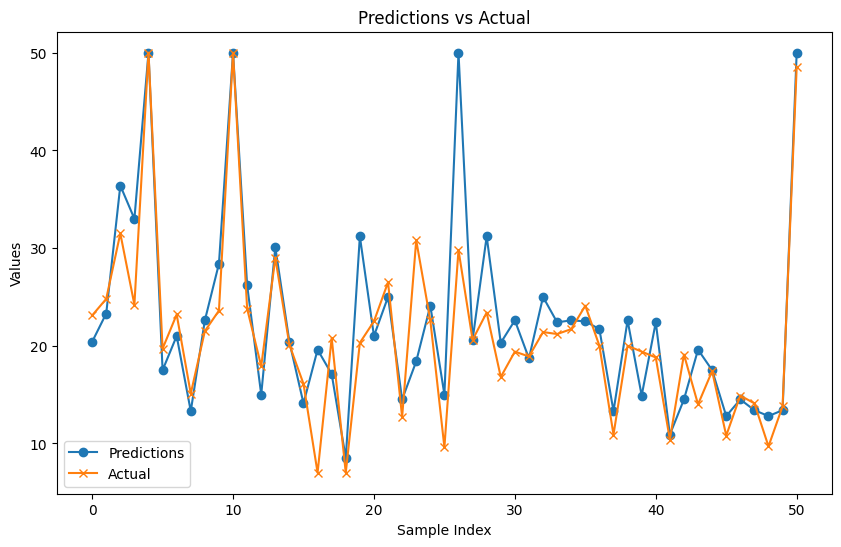

In [16]:
predictions, ground_truth = stk.predict(X_train,y_train,X_test,y_test)
print('Predicted : ',predictions)
print('Actual Values : ',ground_truth.reshape(1,-1))
MyDecisionTreeRegressor().plot_predictions_vs_actual(predictions=predictions, actual=ground_truth)

In [17]:
mse_ensemble,rmse,r_squared = stk.getMetrics()
print('Mean Squared Error : ',mse_ensemble)
print('Root Mean Squared Error : ',rmse)
print('R-Squared Error : ',r_squared)


Mean Squared Error :  25.12352941176471
Root Mean Squared Error :  5.012337719244854
R-Squared Error :  0.697138442774278


### Hyperparameter-Tuning for Regression

In [132]:
level1_list = ['DecisionTreeRegressor','LinearRegressor']
methods_list = ['stacking','blending']
h_vals = [0.1,0.2,0.3,0.4]
k_vals = [7,5,3]

for level1_model in level1_list:
    for method in methods_list:
        if method == 'stacking':
            for k in k_vals:
                h = 0.1
                wandb.init(
                    # set the wandb project where this run will be logged
                    project="Stacking Regressor",

                    # track hyperparameters and run metadata
                    config={
                    'level1_model' : level1_model,
                    'method' : method,
                    'number of folds' : k,
                    'holdout fraction' : None
                    }
                )                    
                stk = Stacking(level1_model,method)
                stk.fit_level1_estimator(k,h,X_train,y_train)
                predictions, ground_truth = stk.predict(X_train,y_train,X_test,y_test)
                mse,rmse,r_squared = stk.getMetrics()
                wandb.log({"MSE": mse,"RMSE":rmse,"R-squared":r_squared})
        else:
            for h in h_vals:
                k = 5
                wandb.init(
                    # set the wandb project where this run will be logged
                    project="Stacking Regressor",

                    # track hyperparameters and run metadata
                    config={
                    'level1_model' : level1_model,
                    'method' : method,
                    'number of folds' : None,
                    'holdout fraction' : h
                    }
                )                    
                stk = Stacking(level1_model,method)
                stk.fit_level1_estimator(k,h,X_train,y_train)
                predictions, ground_truth = stk.predict(X_train,y_train,X_test,y_test)
                mse,rmse,r_squared = stk.getMetrics()
                wandb.log({"MSE": mse,"RMSE":rmse,"R-squared":r_squared})


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: tejas591995. Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.72471
R-squared,0.77428
RMSE,4.32721


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,25.11431
R-squared,0.69725
RMSE,5.01142


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.15
R-squared,0.7812
RMSE,4.26028


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,69.65922
R-squared,0.16027
RMSE,8.34621


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,39.54902
R-squared,0.52324
RMSE,6.2888


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.94804
R-squared,0.90419
RMSE,2.81923


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.10451
R-squared,0.82997
RMSE,3.7556


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.38334
R-squared,0.83867
RMSE,3.65832


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.26676
R-squared,0.86418
RMSE,3.3566


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.42838
R-squared,0.87429
RMSE,3.2293


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,123.00128
R-squared,-0.48277
RMSE,11.09059


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,1404.78502
R-squared,-15.93454
RMSE,37.48046


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,30.74658
R-squared,0.62935
RMSE,5.54496


### Results
The best performing model has the following hyper-parameters :-
- method : blending
- hold-out fraction : 0.3
- MSE : 7.9
- R-squared : 0.9

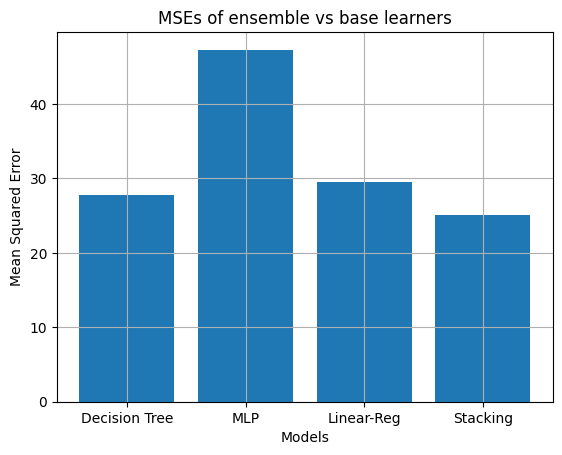

In [22]:
#1st base model : DT Regressor
model = MyDecisionTreeRegressor()
model.fit(X_train,y_train,X_train,y_train)
predictions1 = model.predict(X_test,y_test)

# 2nd model : MLP-Regressor
layer_sizes = [13,5,5,1]
batch_size = 10
num_epoches = 500
learning_rate = 0.0001
activation_function = 'ReLU'
optimization = 'mini-batch'
mlp = MLP_Regressor(layer_sizes=layer_sizes,
        batch_size=batch_size,
        num_epoches=num_epoches,
        learning_rate=learning_rate,
        activation_function=activation_function,
        optimization=optimization,
        )
mlp.loadData(df)
mlp.fit(X_train,y_train,X_train,y_train)
predictions2 = mlp.predict(X_test,y_test)


# 3rd base Model : Linear Regression
model = LinearRegressor()
model.fit(X_train,y_train)
predictions3 = model.predict(X_test,y_test)

mse1 = mean_squared_error(y_pred=predictions1,y_true=y_test)
mse2 = mean_squared_error(y_pred=predictions2,y_true=y_test)
mse3 = mean_squared_error(y_pred=predictions3,y_true=y_test)



values = [mse1, mse2, mse3, mse_ensemble]
labels = ['Decision Tree', 'MLP', 'Linear-Reg', 'Stacking']

# Create a bar chart
plt.bar(labels, values)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.grid()
plt.title('MSEs of ensemble vs base learners')

# Show the plot
plt.show()


In [24]:
print('MSE')
print('DecisionTreeClassifier : ',mse1)
print('Multi-Layer-Perceptron : ',mse2)
print('Logistic Regression    : ',mse3)
print('Stacking Ensemble    : ',mse_ensemble)


MSE
DecisionTreeClassifier :  27.765000000000004
Multi-Layer-Perceptron :  47.29409134978672
Logistic Regression    :  29.550254265557825
Stacking Ensemble    :  25.12352941176471
